In [ ]:
import os
import cv2
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')
DRIVE_ZIP = "/content/drive/MyDrive/CircuitGuard_Project/new PCB _ds.zip"
ROOT_DIR = "/content"
IMAGES_DIR = f"{ROOT_DIR}/new PCB _ds/images"
TEMPLATE_DIR = f"{ROOT_DIR}/new PCB _ds/PCB_USED"
OUTPUT_MASK_DIR = f"{ROOT_DIR}/defect_masks_clean/defect_masks"

if os.path.exists(OUTPUT_MASK_DIR): shutil.rmtree(OUTPUT_MASK_DIR)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

if not os.path.exists(IMAGES_DIR):
    print("📂 Unzipping Dataset...")
    !unzip -q "{DRIVE_ZIP}" -d "{ROOT_DIR}"


In [ ]:

def align_images(img_template, img_test):
    gray_temp = cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY)
    gray_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(nfeatures=5000)
    kp1, des1 = orb.detectAndCompute(gray_temp, None)
    kp2, des2 = orb.detectAndCompute(gray_test, None)

    if des1 is None or des2 is None: return None

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    good_matches = matches[:int(len(matches) * 0.15)]
    if len(good_matches) < 4: return None

    # Compute Homography
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Warp Perspective
    h, w = gray_temp.shape
    aligned = cv2.warpPerspective(img_test, H, (w, h))
    return aligned

def create_mask(img_template, img_aligned):
    # Blur to reduce noise
    blur_t = cv2.GaussianBlur(img_template, (5, 5), 0)
    blur_a = cv2.GaussianBlur(img_aligned, (5, 5), 0)

    # Subtraction
    diff = cv2.absdiff(blur_t, blur_a)
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Thresholding (Otsu)
    _, mask = cv2.threshold(gray_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Cleaning (Morphological Opening)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    return mask_clean


Mounted at /content/drive
📂 Unzipping Dataset...
🚀 Starting Mask Generation...


Missing_hole: 100%|██████████| 115/115 [02:19<00:00,  1.22s/it]



✅ Module 1 Complete. Generated 693 Defect Masks.
💾 Clean masks saved to: /content/drive/MyDrive/CircuitGuard_Project/defect_masks_clean.zip

--- Sample Masks ---


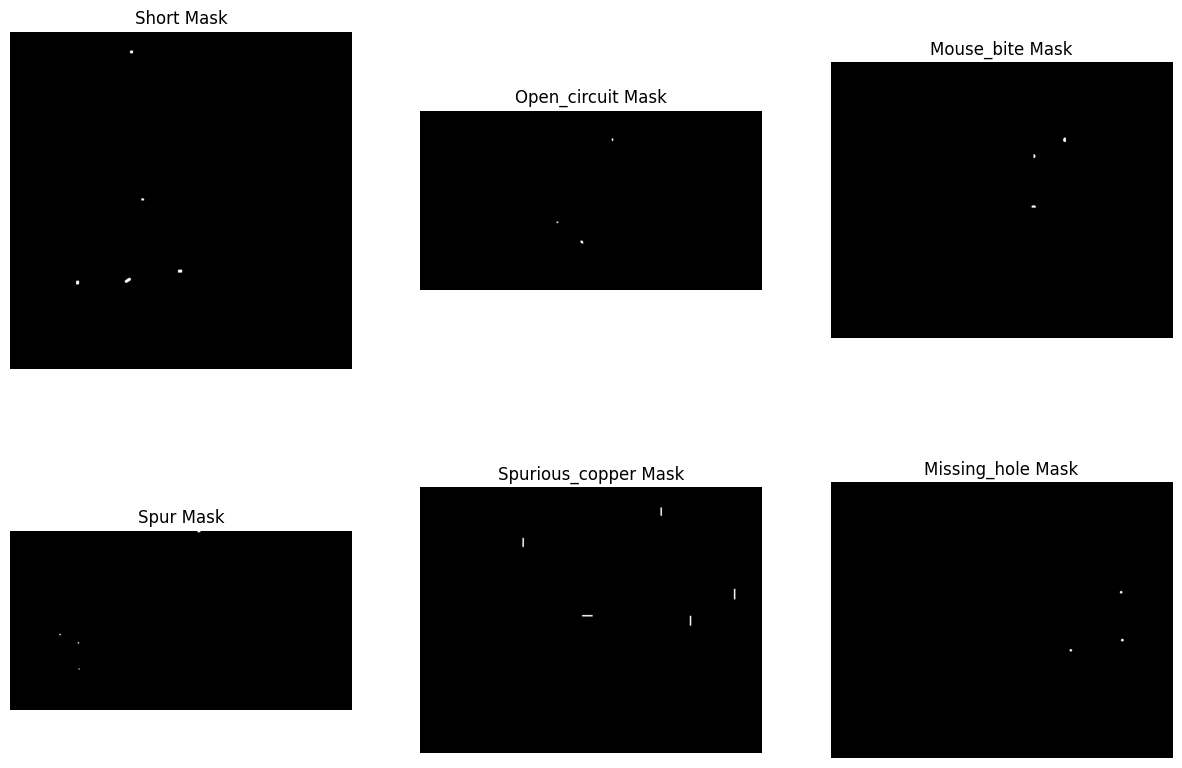

In [ ]:
defect_types = ['Short', 'Open_circuit', 'Mouse_bite', 'Spur', 'Spurious_copper', 'Missing_hole']
print("🚀 Starting Mask Generation...")

count = 0
samples_viz = []

for dtype in defect_types:
    type_dir = os.path.join(IMAGES_DIR, dtype)
    save_dir = os.path.join(OUTPUT_MASK_DIR, dtype)
    os.makedirs(save_dir, exist_ok=True)

    test_files = glob.glob(os.path.join(type_dir, "*.jpg")) + glob.glob(os.path.join(type_dir, "*.JPG"))

    for t_file in tqdm(test_files, desc=dtype):
        filename = os.path.basename(t_file)
        file_id = filename.split('_')[0]

        temp_path_1 = os.path.join(TEMPLATE_DIR, f"{file_id}.JPG")
        temp_path_2 = os.path.join(TEMPLATE_DIR, f"{file_id}.jpg")

        if os.path.exists(temp_path_1):
            temp_file = temp_path_1
        elif os.path.exists(temp_path_2):
            temp_file = temp_path_2
        else:
            continue

        img_test = cv2.imread(t_file)
        img_temp = cv2.imread(temp_file)

        if img_test is None or img_temp is None: continue

        img_aligned = align_images(img_temp, img_test)
        if img_aligned is None: continue

        mask = create_mask(img_temp, img_aligned)

        save_name = filename.replace(".jpg", "_mask.png").replace(".JPG", "_mask.png")
        cv2.imwrite(os.path.join(save_dir, save_name), mask)
        count += 1

        if len(samples_viz) < len(defect_types) and dtype not in [x[0] for x in samples_viz]:
            samples_viz.append((dtype, mask))

print(f"\n✅ Module 1 Complete. Generated {count} Defect Masks.")
!zip -q -r /content/defect_masks_clean.zip /content/defect_masks_clean
!cp /content/defect_masks_clean.zip /content/drive/MyDrive/CircuitGuard_Project/
print("💾 Clean masks saved to: /content/drive/MyDrive/CircuitGuard_Project/defect_masks_clean.zip")
print("\n--- Sample Masks ---")
plt.figure(figsize=(15, 10))
for i, (label, mask) in enumerate(samples_viz):
    plt.subplot(2, 3, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"{label} Mask")
    plt.axis('off')
plt.show()